<a href="https://colab.research.google.com/github/milanpavikevik/GenreClassifier/blob/master/Music_genre_classification_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')
%pylab inline
import os
import glob
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa.display

# Scikit learn
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix                   
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


# Connecting to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data read

In [3]:
INPUT_DIR=f'/content/drive/My Drive/Songs/all_songs/'
genres = ['classical','hip_hop_rap','metal','pop','turbofolk','techno','rock','narodni','jazz']

In [4]:
dataset = []
for genre in genres:
  directory = INPUT_DIR + genre + '/**'
  for filename in glob.iglob(directory):
    if os.path.exists(filename):
        label = genre
        duration = librosa.get_duration(filename=filename)
        print('label',label,'duration',duration)
        # skip audio smaller than 3 secs
        if duration>=65 and duration <=600:
            slice_size = 5
            initial_offset = 60
            iterations = 3
            print ('song: ',filename,'initial_offset: ',initial_offset,'iterations: ',iterations,'duration: ',duration)
            for i in range(iterations):
                offset = initial_offset + i*(slice_size-1)
                if (label=="classical"):
                    dataset.append({
                        "filename": filename,
                        "label": "classical",
                        "offset": offset
                        })
                elif (label == 'techno'):
                    dataset.append({
                        "filename": filename,
                        "label": "techno",
                        "offset": offset
                        })
                elif (label == 'hip_hop_rap'):
                    dataset.append({
                      "filename": filename,
                      "label": "hip_hop_rap",
                      "offset": offset
                      })
                elif (label == 'metal'):
                    dataset.append({
                      "filename": filename,
                      "label": "metal",
                      "offset": offset
                      })
                elif (label == 'pop'):
                    dataset.append({
                      "filename": filename,
                      "label": "pop",
                      "offset": offset
                      })
                elif (label == 'turbofolk'):
                    dataset.append({
                      "filename": filename,
                      "label": "turbofolk",
                      "offset": offset
                      })
                elif (label == 'narodni'):
                    dataset.append({
                      "filename": filename,
                      "label": "narodni",
                      "offset": offset
                      })
                elif (label == 'jazz'):
                    dataset.append({
                      "filename": filename,
                      "label": "jazz",
                      "offset": offset
                      })
                elif (label == 'rock'):
                    dataset.append({
                      "filename": filename,
                      "label": "rock",
                      "offset": offset
                      })

label classical duration 298.0
song:  /content/drive/My Drive/Songs/all_songs/classical/Frédéric Chopin - Nocturne Op. 27 No. 1 (Piano Solo).mp3 initial_offset:  60 iterations:  3 duration:  298.0
label classical duration 177.0
song:  /content/drive/My Drive/Songs/all_songs/classical/Antonio Vivaldi- The Four Seasons- Summer- Presto.mp3 initial_offset:  60 iterations:  3 duration:  177.0
label classical duration 263.3
song:  /content/drive/My Drive/Songs/all_songs/classical/Mussorgsky - Pictures at an Exhibition - The Old Castle.mp3 initial_offset:  60 iterations:  3 duration:  263.3
label classical duration 324.7
song:  /content/drive/My Drive/Songs/all_songs/classical/(HD) Beethoven "Sonata Pathétique"- 2nd mvt  Adagio cantabile.mp3 initial_offset:  60 iterations:  3 duration:  324.7
label classical duration 459.6
song:  /content/drive/My Drive/Songs/all_songs/classical/Saint-Saëns - Organ Symphony, Finale!!!.mp3 initial_offset:  60 iterations:  3 duration:  459.6
label classical

# Preprocessing

In [5]:
#Fast Fourier Transform
import scipy
def fft_plot(audio,sampling_rate,label):
  n = len(audio)
  T = 1/sampling_rate
  yf=scipy.fft(audio)
  xf=np.linspace(0,1.0/(2.0*T),int(n/2))
  fig,ax = plt.subplots()
  ax.plot(xf,2.0/n* np.abs(yf[:n//2]))
  plt.grid()
  plt.xlabel('Frequency ------->')
  plt.ylabel('Magnitude')
  plt.title(label)
  plt.show()


#Extract MFCC from spectogram
def extract_features(audio_path,offset):

    y, sr = librosa.load(audio_path, offset=offset, duration=4.5)

    
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    vector = np.empty
    vector = np.append(vector, np.mean(chroma_stft))
    vector = np.append(vector, np.mean(spec_cent))
    vector = np.append(vector,np.mean(spec_bw))
    vector = np.append(vector,np.mean(rolloff))
    vector = np.append(vector,np.mean(zcr))
    for e in mfcc:
            vector = np.append(vector,np.mean(e))

    vector = np.delete(vector,0,0)


    return vector


In [6]:
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 1610 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1944 non-null   object
 1   label     1944 non-null   object
 2   offset    1944 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 60.8+ KB


In [7]:
nuli = []
for i in range(649,len(dataset)):
  y,sr = librosa.load(dataset.filename.iloc[i], duration=3)
  if y.any() == 0:
    nuli.append(i)

In [8]:
dataset = dataset.drop(index=nuli)

In [9]:
len(dataset)

1892

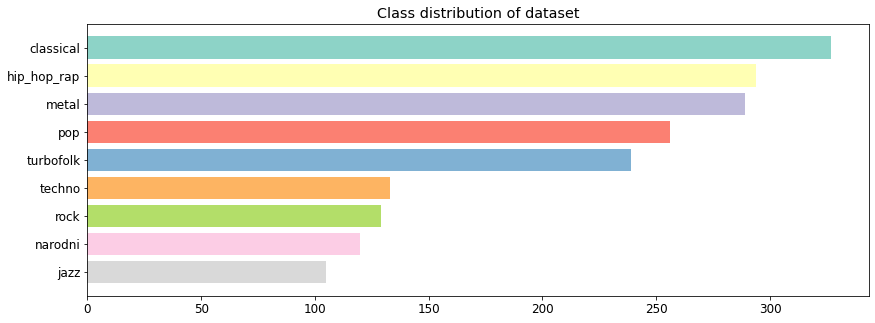

In [10]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 5)
matplotlib.rcParams['font.size'] = 12
from matplotlib import pyplot as plt

num_classes = 9
class_counts = dataset.label.value_counts()
cmap = plt.cm.get_cmap(plt.cm.Set3, 10)
colors = [cmap(i) for i in range(num_classes)]
plt.barh(range(num_classes)[::-1], class_counts, tick_label=genres,
         color=colors)
plt.title('Class distribution of dataset')
plt.show()

In [11]:
train, test = train_test_split(dataset, test_size=0.25, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1419
Test: 473


In [12]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|██████████| 473/473 [05:54<00:00,  1.33it/s]

X train: (1419, 25)
X test: (473, 25)


In [13]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train.label)
y_test = encoder.fit_transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

In [14]:
scaler = StandardScaler()
x_train = scaler.fit_transform(np.array(x_train, dtype = float))
x_test = scaler.fit_transform(np.array(x_test, dtype = float))

In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1419, 25)
(1419,)
(473, 25)
(473,)


In [16]:
import sklearn

def confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_cnf(model,dataset_x,dataset_y,GENRES):
    true_y=dataset_y
    true_x=dataset_x
    pred=model.predict(true_x)

    print("---------------PERFORMANCE ANALYSIS FOR THE MODEL----------------\n")

    print("Real Test dataset labels: \n{}\n".format(true_y))
    print("Predicted Test dataset labels: \n{}".format(pred))

    cnf_matrix=sklearn.metrics.confusion_matrix(true_y,pred)
    plt.figure()
    a=confusion_matrix(cnf_matrix,classes=GENRES,title='Confusion matrix')

# K-Nearest Neighbor

Max Accuracy is 0.820 on test dataset with 1 neighbors.

Training Score: 0.991
Test score: 0.820
---------------PERFORMANCE ANALYSIS FOR THE MODEL----------------

Real Test dataset labels: 
[7 4 6 2 8 3 1 4 5 1 3 1 7 1 3 8 3 0 2 5 6 6 3 1 5 2 3 5 5 2 0 4 1 0 8 3 7
 1 3 1 7 6 1 5 3 5 5 5 3 1 6 6 8 2 3 6 5 7 7 0 6 1 5 1 3 1 1 1 6 7 3 8 3 4
 5 2 3 1 2 5 1 5 6 6 4 1 3 5 5 2 2 1 1 1 1 4 3 3 5 6 6 6 5 6 1 6 6 8 1 2 1
 5 1 3 8 5 0 4 1 5 2 5 1 8 8 3 7 0 6 0 1 2 3 5 0 5 3 6 7 2 5 1 6 2 6 1 7 5
 3 6 1 0 5 1 3 6 6 3 1 3 6 4 6 7 5 5 6 5 4 4 8 3 3 3 2 1 6 2 8 1 1 7 2 4 2
 4 0 6 2 3 4 3 1 4 5 7 1 2 3 6 4 8 1 2 3 1 1 3 0 2 5 3 8 1 3 1 2 2 1 1 2 8
 4 6 5 7 6 5 0 5 4 6 3 4 4 6 3 2 0 7 3 2 7 2 2 5 3 2 0 0 1 6 4 4 3 2 1 3 6
 7 6 0 6 6 7 0 6 5 5 2 3 2 0 0 5 2 6 1 5 2 6 6 5 6 8 6 5 2 7 6 3 1 1 5 6 6
 2 4 6 7 1 1 3 6 5 6 7 7 4 7 1 2 5 4 5 8 6 3 3 5 4 1 2 2 0 5 0 2 2 3 1 3 2
 1 2 2 6 6 5 1 3 0 2 1 3 1 3 0 5 5 7 5 5 1 0 6 1 3 3 3 1 1 5 1 7 0 1 6 3 5
 6 4 3 8 2 7 6 6 3 1 6 6 6 2 1 6 2 1 2 3 4 3 1 8 2 2 6 3 1 

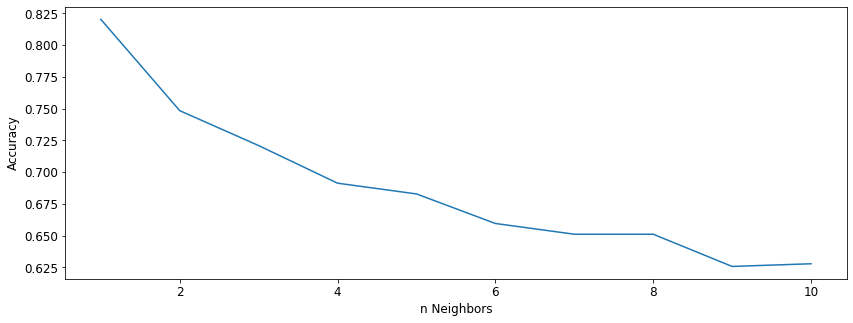

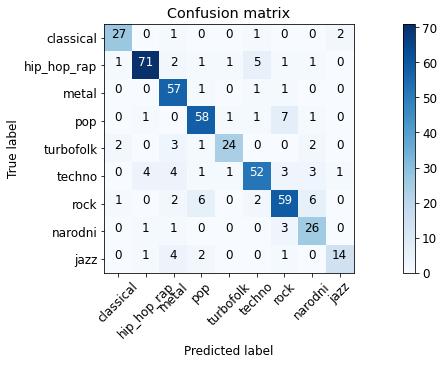

In [36]:
from sklearn.neighbors import KNeighborsClassifier

results_knn=[]
for i in range(1,11):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    results_knn.append(knn.score(x_test,y_test))
    
max_accuracy_knn=max(results_knn)
best_k=1+results_knn.index(max(results_knn))
print("Max Accuracy is {:.3f} on test dataset with {} neighbors.\n".format(max_accuracy_knn,best_k))

plt.plot(numpy.arange(1,11),results_knn)
plt.xlabel("n Neighbors")
plt.ylabel("Accuracy")


knn=KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train,y_train)
print("Training Score: {:.3f}".format(knn.score(x_train,y_train)))
print("Test score: {:.3f}".format(knn.score(x_test,y_test)))  

plot_cnf(knn,x_test,y_test,genres)

# Random Forest

Max Accuracy is 0.693 on test dataset with 55 estimators.

Training Score: 0.991
Test score: 0.693
---------------PERFORMANCE ANALYSIS FOR THE MODEL----------------

Real Test dataset labels: 
[7 4 6 2 8 3 1 4 5 1 3 1 7 1 3 8 3 0 2 5 6 6 3 1 5 2 3 5 5 2 0 4 1 0 8 3 7
 1 3 1 7 6 1 5 3 5 5 5 3 1 6 6 8 2 3 6 5 7 7 0 6 1 5 1 3 1 1 1 6 7 3 8 3 4
 5 2 3 1 2 5 1 5 6 6 4 1 3 5 5 2 2 1 1 1 1 4 3 3 5 6 6 6 5 6 1 6 6 8 1 2 1
 5 1 3 8 5 0 4 1 5 2 5 1 8 8 3 7 0 6 0 1 2 3 5 0 5 3 6 7 2 5 1 6 2 6 1 7 5
 3 6 1 0 5 1 3 6 6 3 1 3 6 4 6 7 5 5 6 5 4 4 8 3 3 3 2 1 6 2 8 1 1 7 2 4 2
 4 0 6 2 3 4 3 1 4 5 7 1 2 3 6 4 8 1 2 3 1 1 3 0 2 5 3 8 1 3 1 2 2 1 1 2 8
 4 6 5 7 6 5 0 5 4 6 3 4 4 6 3 2 0 7 3 2 7 2 2 5 3 2 0 0 1 6 4 4 3 2 1 3 6
 7 6 0 6 6 7 0 6 5 5 2 3 2 0 0 5 2 6 1 5 2 6 6 5 6 8 6 5 2 7 6 3 1 1 5 6 6
 2 4 6 7 1 1 3 6 5 6 7 7 4 7 1 2 5 4 5 8 6 3 3 5 4 1 2 2 0 5 0 2 2 3 1 3 2
 1 2 2 6 6 5 1 3 0 2 1 3 1 3 0 5 5 7 5 5 1 0 6 1 3 3 3 1 1 5 1 7 0 1 6 3 5
 6 4 3 8 2 7 6 6 3 1 6 6 6 2 1 6 2 1 2 3 4 3 1 8 2 2 6 3 

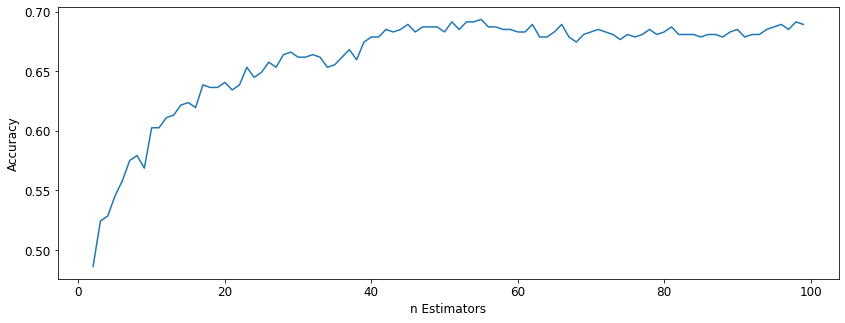

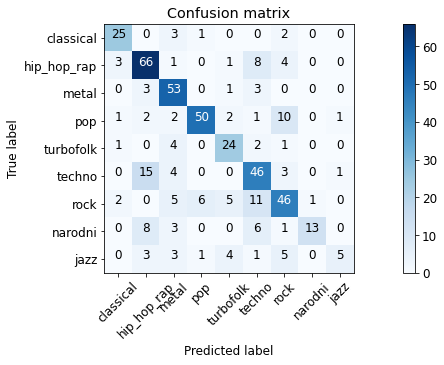

In [18]:
from sklearn.ensemble import RandomForestClassifier

results_forest=[]
for i in range(2,100):
    forest=RandomForestClassifier(random_state=42,n_estimators=i)
    forest.fit(x_train,y_train)
    results_forest.append(forest.score(x_test,y_test))
    
max_accuracy_forest=max(results_forest)
best_n_est=2+results_forest.index(max(results_forest))
print("Max Accuracy is {:.3f} on test dataset with {} estimators.\n".format(max_accuracy_forest,best_n_est))

plt.plot(numpy.arange(2,100),results_forest)
plt.xlabel("n Estimators")
plt.ylabel("Accuracy")


forest=RandomForestClassifier(random_state=42,n_estimators=best_n_est)
forest.fit(x_train,y_train)
print("Training Score: {:.3f}".format(forest.score(x_train,y_train)))
print("Test score: {:.3f}".format(forest.score(x_test,y_test)))

plot_cnf(forest,x_test,y_test,genres)

# Support Vector Machine

Training Score: 0.990
Test score: 0.810
---------------PERFORMANCE ANALYSIS FOR THE MODEL----------------

Real Test dataset labels: 
[7 4 6 2 8 3 1 4 5 1 3 1 7 1 3 8 3 0 2 5 6 6 3 1 5 2 3 5 5 2 0 4 1 0 8 3 7
 1 3 1 7 6 1 5 3 5 5 5 3 1 6 6 8 2 3 6 5 7 7 0 6 1 5 1 3 1 1 1 6 7 3 8 3 4
 5 2 3 1 2 5 1 5 6 6 4 1 3 5 5 2 2 1 1 1 1 4 3 3 5 6 6 6 5 6 1 6 6 8 1 2 1
 5 1 3 8 5 0 4 1 5 2 5 1 8 8 3 7 0 6 0 1 2 3 5 0 5 3 6 7 2 5 1 6 2 6 1 7 5
 3 6 1 0 5 1 3 6 6 3 1 3 6 4 6 7 5 5 6 5 4 4 8 3 3 3 2 1 6 2 8 1 1 7 2 4 2
 4 0 6 2 3 4 3 1 4 5 7 1 2 3 6 4 8 1 2 3 1 1 3 0 2 5 3 8 1 3 1 2 2 1 1 2 8
 4 6 5 7 6 5 0 5 4 6 3 4 4 6 3 2 0 7 3 2 7 2 2 5 3 2 0 0 1 6 4 4 3 2 1 3 6
 7 6 0 6 6 7 0 6 5 5 2 3 2 0 0 5 2 6 1 5 2 6 6 5 6 8 6 5 2 7 6 3 1 1 5 6 6
 2 4 6 7 1 1 3 6 5 6 7 7 4 7 1 2 5 4 5 8 6 3 3 5 4 1 2 2 0 5 0 2 2 3 1 3 2
 1 2 2 6 6 5 1 3 0 2 1 3 1 3 0 5 5 7 5 5 1 0 6 1 3 3 3 1 1 5 1 7 0 1 6 3 5
 6 4 3 8 2 7 6 6 3 1 6 6 6 2 1 6 2 1 2 3 4 3 1 8 2 2 6 3 1 8 1 3 2 2 6 1 1
 2 5 1 1 5 5 2 2 1 4 7 0 0 3 3 0 4 7 6 1 

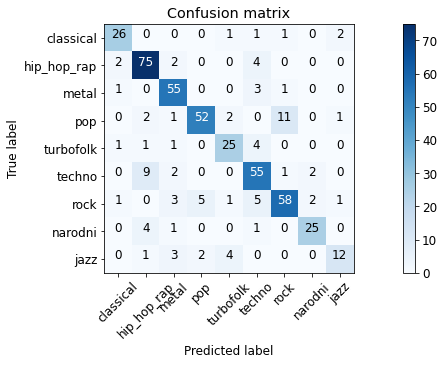

In [35]:
from sklearn.svm import SVC

svm=SVC(C=10,gamma=0.1)
svm.fit(x_train,y_train)
print("Training Score: {:.3f}".format(svm.score(x_train,y_train)))
print("Test score: {:.3f}".format(svm.score(x_test,y_test)))

plot_cnf(svm,x_test,y_test,genres)

# Neural Network

Training Score: 0.991
Test score: 0.734
---------------PERFORMANCE ANALYSIS FOR THE MODEL----------------

Real Test dataset labels: 
[7 4 6 2 8 3 1 4 5 1 3 1 7 1 3 8 3 0 2 5 6 6 3 1 5 2 3 5 5 2 0 4 1 0 8 3 7
 1 3 1 7 6 1 5 3 5 5 5 3 1 6 6 8 2 3 6 5 7 7 0 6 1 5 1 3 1 1 1 6 7 3 8 3 4
 5 2 3 1 2 5 1 5 6 6 4 1 3 5 5 2 2 1 1 1 1 4 3 3 5 6 6 6 5 6 1 6 6 8 1 2 1
 5 1 3 8 5 0 4 1 5 2 5 1 8 8 3 7 0 6 0 1 2 3 5 0 5 3 6 7 2 5 1 6 2 6 1 7 5
 3 6 1 0 5 1 3 6 6 3 1 3 6 4 6 7 5 5 6 5 4 4 8 3 3 3 2 1 6 2 8 1 1 7 2 4 2
 4 0 6 2 3 4 3 1 4 5 7 1 2 3 6 4 8 1 2 3 1 1 3 0 2 5 3 8 1 3 1 2 2 1 1 2 8
 4 6 5 7 6 5 0 5 4 6 3 4 4 6 3 2 0 7 3 2 7 2 2 5 3 2 0 0 1 6 4 4 3 2 1 3 6
 7 6 0 6 6 7 0 6 5 5 2 3 2 0 0 5 2 6 1 5 2 6 6 5 6 8 6 5 2 7 6 3 1 1 5 6 6
 2 4 6 7 1 1 3 6 5 6 7 7 4 7 1 2 5 4 5 8 6 3 3 5 4 1 2 2 0 5 0 2 2 3 1 3 2
 1 2 2 6 6 5 1 3 0 2 1 3 1 3 0 5 5 7 5 5 1 0 6 1 3 3 3 1 1 5 1 7 0 1 6 3 5
 6 4 3 8 2 7 6 6 3 1 6 6 6 2 1 6 2 1 2 3 4 3 1 8 2 2 6 3 1 8 1 3 2 2 6 1 1
 2 5 1 1 5 5 2 2 1 4 7 0 0 3 3 0 4 7 6 1 

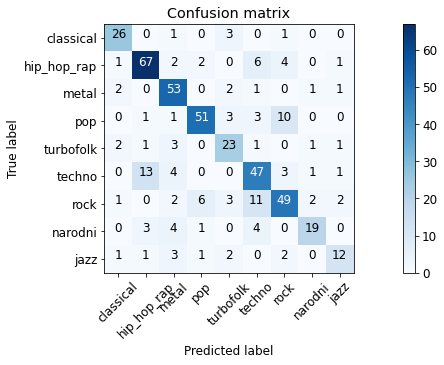

In [20]:
from sklearn.neural_network import MLPClassifier

neural=MLPClassifier(max_iter=400,random_state=2,hidden_layer_sizes=[100,100])
neural.fit(x_train,y_train)
print("Training Score: {:.3f}".format(neural.score(x_train,y_train)))
print("Test score: {:.3f}".format(neural.score(x_test,y_test)))

plot_cnf(neural,x_test,y_test,genres)